# INF200 Lecture No 16
### Hans Ekkehard Plesser / NMBU
### 14 January 2016

## Today's topics

- Exam
- Choosing between alternatives

## Exam

- **Monday, 25 January, 2016**
- Who has other exams that day, and when?
- Format
    - Individual exams
    - Five minute presentation of code and results
    - One PDF file
    - Optionally one animation (MP4 or GIF, created as shown in RandVis example)
    - 15 minute discussion with examiners (Plesser and Sundnes)
    - Your code is available on screen during discussion
- Content of presentation and discussion
    - You are a software developer presenting your product to your client
    - Explain to client how you have solved the task
        - Overall structure of the code
        - Example of how you solved specific aspects
    - Pursuade the client that he/she can trust your code
        - How did you ensure quality?
        - Is code in maintainable shape?
        - Do you as developer know your stuff?
    - Pursuade the client that your code is productive
        - Documentation: Will client's employees be able to use code with ease?
        - Performance: Is the code fast?
    - Show some interesting results
- Evaluation
    - Code evaluation jointly for both team members, 0-70 points
    - Individual evaluation of oral exam, 0-30 points
    - Final grade (A-F) set according to total number of points
    - Criteria
        - Completeness
        - Code quality
            - Correctness of implementation
            - Suitable coding constructs vs unnecessarily complex code
            - Readability of code
            - Pythonic coding style
            - Tidiness (PEP8)
        - Quality control / testing
        - Documentation
        - Your ability to present, explain and discuss the code
        
### Submission of material

#### Project code

- **Deadline: Wednesday, 20 January, 16.00**
- Submit your code as follows, working in our team repository:
    1. Commit you final changes
    1. In SourceTree, right-click the commit with the final changes, choose `Tags ...`
    1. Choose `BiosimSubmission` as tag (no spaces)
    1. Choose `Commit: Specified commit` (should be the commit with the final changes
    1. Check of for `Push tag:` with destination `origin`
    1. Confirm that tag is visible on BitBucket
    1. Create pull request from your `biosim` branch to your `master`
    1. Set `heplesser` and `sundnes` as reviewers
- Tag and pull request must be in place by the deadline.
- Test creating tags before next Wednesday!

#### Presentation files

- **Deadline: Sunday, 24 January, 12.00**
- Submit your material (one PDF, one MP4 or GIF) as follows, working in your **personal repository**:
    1. From `master`, create a branch `exam`
    1. At the top level in the repository, create a folder `Exam`
    1. Put your files into the `Exam` folder
    1. Commit
    1. Add a tag `INF200Exam` to the final commit of the material
    1. Create a pull request from `exam` back to `master`
    1. Set `heplesser` and `sundnes` as reviewers
- Tag and pull request must be in place by the deadline.

## Choosing alternatives

- Literature: Knuth, The Art of Computer Programming, vol 2, ch 3.3-3.4 
- In a simluation, we want to choose between four alternatives with probabilities $p_0, p_1, p_2, p_3$
- Note $\sum_{n=0}^3 p_n = 1$ by definition
- Cumulative probabilities $P_n = \sum_{k=0}^n p_k$ divide unit interval in sections corresponding to events 0, 1, 2, 3
- Specifically, we choose a random number $r$ and select 

\begin{equation}
\begin{cases}
\text{event}\: 0 \quad\text{hvis}\; r < P_0 \\
\text{event}\: n \quad\text{hvis}\; P_{n-1} \leq r < P_{n}\;\; \text{for}\; n>0
\end{cases}
\end{equation}

- The following code shall select events (this method is called the *linear search* method)

In [1]:
import numpy as np
from scipy.stats import chisquare, kstest, probplot
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

np.random.seed(1234567)

In [2]:
p = np.array([1./8, 1./4, 1./2, 1./8])
P = np.cumsum(p)

n_trials = 1000
num_expected = n_trials * p
num_observed = np.zeros_like(p)

for _ in range(n_trials):
    n = 0
    while np.random.random() >= P[n]:
        n += 1
    num_observed[n] +=1
    
for n, (e, o) in enumerate(zip(num_expected, num_observed)):
    print n, e, o

0 125.0 114.0
1 250.0 339.0
2 500.0 488.0
3 125.0 59.0


- Are these results probable if our code were correct?
- We can check with the [$\chi^2$-test](https://en.wikipedia.org/wiki/Chi-squared_test)

In [3]:
chi2, p_value = chisquare(num_observed, num_expected)
print chi2, p_value

67.788 1.27001796468e-14


- The $p$-value of $\sim 10^{-14}$ strongly suggest to reject the null-hypothesis that our code generated results distributed according to the prescribed distribution.
- **What is wrong with our code?**
    - We need to choose **one** random number
    - In the code above, we draw a new random number for each possible event we test for
- The code below is corrected

In [4]:
num_observed = np.zeros_like(p)
for _ in range(n_trials):
    n = 0
    r = np.random.random()
    while r >= P[n]:
        n += 1
    num_observed[n] +=1
    
for n, (e, o) in enumerate(zip(num_expected, num_observed)):
    print n, e, o

0 125.0 123.0
1 250.0 237.0
2 500.0 520.0
3 125.0 120.0


- This looks better, but what does $\chi^2$ say?

In [5]:
chi2, p_value = chisquare(num_observed, num_expected)
print chi2, p_value

1.708 0.635156679561


- $p=0.64$ gives no reason to reject the null hypothesis that our code generated numbers according to the prescribed distribution

### Refactoring the code

- We divide our code into functions, so it becomes easier to run some more experiments
- In the code above, we compute and store the cumulative probability $P$ explicitly. We can avoid this by successively subtracting from the random number $r$ the probabilities $p_n$ we have checked

In [6]:
def random_select(p):
    r = np.random.random()
    n = 0
    while r >= p[n]:
        r -= p[n]
        n += 1
    return n

def event_frequencies(p, num_events):
    event_count = np.zeros_like(p)
    for _ in range(num_events):
        event = random_select(p)
        event_count[event] += 1
    return event_count

def test_random_select(p, num_events):
    num_expected = num_events * p
    num_observed = event_frequencies(p, num_events)
    _, p_value = chisquare(num_observed, num_expected)
    return p_value

In [7]:
print test_random_select(p, 1000)

0.445692778554


- The $p$-value from a single test looks fine

### Repeated tests

- To become even more certain that our random selection scheme works correctly, we can repeat `test_random_select()` many times
- The resulting $p$-values should then be uniformely distributed on $[0, 1]$
- We can test for this using the [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov–Smirnov_test)

In [8]:
p_values = [test_random_select(p, 1000) for _ in range(500)]

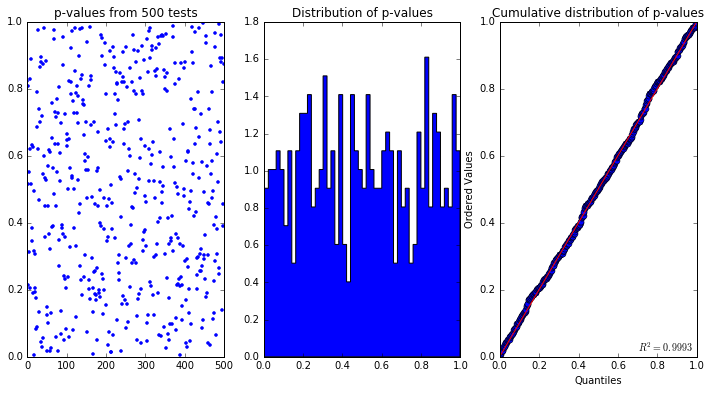

In [9]:
plt.subplot(1, 3, 1)
plt.plot(p_values, '.')
plt.title('p-values from 500 tests')

plt.subplot(1, 3, 2)
plt.hist(p_values, bins=50, histtype='stepfilled', align='mid', normed=True)
plt.title('Distribution of p-values')

plt.subplot(1, 3, 3)
probplot(p_values, dist='uniform', plot=plt)
plt.title('Cumulative distribution of p-values');

In [10]:
_, pval_ks = kstest(p_values, cdf='uniform')
print pval_ks

0.938836866653


- This p-value is rather large, but at the $\alpha=5%$ level does not give reason to reject the null-hypothesis that the p-values from the $\chi^2$-tests are uniformly distributed on $[0, 1]$
- We thus trust our code